In [1]:
import pandas as pd

# Load the uploaded dataset
file_path = 'realistic_p2p_solar_trading.csv'
df = pd.read_csv(file_path)

# Show basic information and first few rows
df_info = df.info()
df_head = df.head()

df_info, df_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         2880 non-null   object 
 1   household         2880 non-null   object 
 2   solar_kWh         2880 non-null   float64
 3   load_kWh          2880 non-null   float64
 4   price_per_kWh     2880 non-null   float64
 5   transaction_type  2880 non-null   object 
dtypes: float64(3), object(3)
memory usage: 135.1+ KB


(None,
              timestamp household  solar_kWh  load_kWh  price_per_kWh  \
 0  2023-06-01 00:00:00        H4        0.0      0.45          0.120   
 1  2023-06-01 00:15:00        H5        0.0      0.77          0.121   
 2  2023-06-01 00:30:00        H3        0.0      0.51          0.122   
 3  2023-06-01 00:45:00        H5        0.0      0.50          0.123   
 4  2023-06-01 01:00:00        H5        0.0      0.54          0.124   
 
     transaction_type  
 0  GENERATION/DEMAND  
 1  GENERATION/DEMAND  
 2  GENERATION/DEMAND  
 3  GENERATION/DEMAND  
 4  GENERATION/DEMAND  )

In [2]:
import numpy as np

# Step 1: Calculate net energy (surplus or deficit)
df['net_kWh'] = df['solar_kWh'] - df['load_kWh']

# Step 2: Group by timestamp and identify surplus and deficit households
trades = []

# Convert timestamp to datetime for proper grouping
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Group data by timestamp
for timestamp, group in df.groupby('timestamp'):
    surplus_group = group[group['net_kWh'] > 0].copy()
    deficit_group = group[group['net_kWh'] < 0].copy()
    
    # Sort surplus households by descending surplus
    surplus_group.sort_values(by='net_kWh', ascending=False, inplace=True)
    
    # Sort deficit households by ascending deficit (most in need first)
    deficit_group.sort_values(by='net_kWh', ascending=True, inplace=True)

    # Matching: greedy approach
    for _, buyer in deficit_group.iterrows():
        energy_needed = abs(buyer['net_kWh'])
        
        for s_idx, seller in surplus_group.iterrows():
            if seller['net_kWh'] <= 0:
                continue  # Already matched fully

            energy_available = seller['net_kWh']
            traded_energy = min(energy_needed, energy_available)
            trade_price = (buyer['price_per_kWh'] + seller['price_per_kWh']) / 2

            # Log the trade
            trades.append({
                'timestamp': timestamp,
                'buyer': buyer['household'],
                'seller': seller['household'],
                'energy_kWh': traded_energy,
                'price_per_kWh': trade_price,
                'total_cost': traded_energy * trade_price
            })

            # Update seller's and buyer's net energy
            surplus_group.at[s_idx, 'net_kWh'] -= traded_energy
            energy_needed -= traded_energy

            if energy_needed <= 0:
                break  # Buyer's demand fulfilled

# Convert trades to DataFrame
trades_df = pd.DataFrame(trades)
trades_df.head()


""


It looks like no P2P trades were generated. This likely means that at the given timestamps, no households had a positive energy surplus (i.e., solar_kWh - load_kWh > 0 was not satisfied). Let's confirm this by checking how many records actually show a surplus or deficit.

In [3]:
# Count records with surplus and deficit
surplus_count = (df['net_kWh'] > 0).sum()
deficit_count = (df['net_kWh'] < 0).sum()

surplus_count, deficit_count


(np.int64(1033), np.int64(1846))

The dataset does contain 1,033 surplus and 1,846 deficit records, so in principle, P2P trading should be possible.

However, the issue might be that at each timestamp, there are no matching surplus and deficit households—i.e., no overlap in time between producers and consumers.

Let’s check one timestamp where both surplus and deficit households exist, and manually inspect the group.

In [4]:
# Find a timestamp that has both surplus and deficit households
matching_timestamps = []

for timestamp, group in df.groupby('timestamp'):
    surplus_exists = (group['net_kWh'] > 0).any()
    deficit_exists = (group['net_kWh'] < 0).any()
    if surplus_exists and deficit_exists:
        matching_timestamps.append(timestamp)

# Display first matching timestamp and corresponding group
first_valid_timestamp = matching_timestamps[0]
valid_group = df[df['timestamp'] == first_valid_timestamp]

first_valid_timestamp, valid_group[['household', 'solar_kWh', 'load_kWh', 'net_kWh']]


IndexError: list index out of range

The error confirms that there are no timestamps where both surplus and deficit households exist simultaneously in the dataset. This explains why the P2P trading simulation didn't generate any results.

🔍 Why This Happens:
Your dataset is structured such that:

At any given 15-minute interval, either all households are consuming or none are generating enough to sell.

No overlap exists between producers and consumers at the same time, which is required for real-time P2P trading. 


solution: Aggregate Over Time
Instead of real-time trading, group data hourly or daily to increase the chance of matching surplus and deficit energy. i choose hourly.

In [5]:
# Step 1: Round timestamps to the nearest hour
df['timestamp_hourly'] = df['timestamp'].dt.floor('H')

# Step 2: Aggregate data per household per hour
hourly_df = df.groupby(['timestamp_hourly', 'household']).agg({
    'solar_kWh': 'sum',
    'load_kWh': 'sum',
    'price_per_kWh': 'mean'  # Average price in the hour
}).reset_index()

# Step 3: Calculate net energy
hourly_df['net_kWh'] = hourly_df['solar_kWh'] - hourly_df['load_kWh']

# Show a sample of the aggregated dataset
hourly_df.head()


C:\Users\HP\AppData\Local\Temp\ipykernel_13492\389815879.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp_hourly'] = df['timestamp'].dt.floor('H')


,timestamp_hourly,household,solar_kWh,load_kWh,price_per_kWh,net_kWh
0,2023-06-01 00:00:00,H3,0.0,0.51,0.1220,-0.51
1,2023-06-01 00:00:00,H4,0.0,0.45,0.1200,-0.45
2,2023-06-01 00:00:00,H5,0.0,1.27,0.1220,-1.27
3,2023-06-01 01:00:00,H2,0.0,0.80,0.1250,-0.80
4,2023-06-01 01:00:00,H3,0.0,1.43,0.1265,-1.43


The dataset has now been successfully aggregated by hour for each household, with net energy (net_kWh) calculated.

This should increase the likelihood of matching surplus and deficit households at the same timestamp. Next, I’ll rerun the P2P matching model using this hourly-aggregated data.

In [6]:
# Step 4: P2P matching using hourly data
hourly_trades = []

# Group by hourly timestamp
for timestamp, group in hourly_df.groupby('timestamp_hourly'):
    surplus_group = group[group['net_kWh'] > 0].copy()
    deficit_group = group[group['net_kWh'] < 0].copy()

    # Sort surplus (most surplus first) and deficit (most deficit first)
    surplus_group.sort_values(by='net_kWh', ascending=False, inplace=True)
    deficit_group.sort_values(by='net_kWh', ascending=True, inplace=True)

    for _, buyer in deficit_group.iterrows():
        energy_needed = abs(buyer['net_kWh'])

        for s_idx, seller in surplus_group.iterrows():
            if seller['net_kWh'] <= 0:
                continue

            energy_available = seller['net_kWh']
            traded_energy = min(energy_needed, energy_available)
            trade_price = (buyer['price_per_kWh'] + seller['price_per_kWh']) / 2

            hourly_trades.append({
                'timestamp': timestamp,
                'buyer': buyer['household'],
                'seller': seller['household'],
                'energy_kWh': traded_energy,
                'price_per_kWh': trade_price,
                'total_cost': traded_energy * trade_price
            })

            # Update seller's remaining surplus
            surplus_group.at[s_idx, 'net_kWh'] -= traded_energy
            energy_needed -= traded_energy

            if energy_needed <= 0:
                break

# Create DataFrame of simulated trades
hourly_trades_df = pd.DataFrame(hourly_trades)
hourly_trades_df.head()


,timestamp,buyer,seller,energy_kWh,price_per_kWh,total_cost
0,2023-06-02 15:00:00,H3,H4,0.10,0.2200,0.022000
1,2023-06-03 07:00:00,H2,H3,0.23,0.2005,0.046115
2,2023-06-03 07:00:00,H1,H3,0.03,0.2000,0.006000
3,2023-06-05 07:00:00,H4,H5,0.15,0.0360,0.005400
4,2023-06-05 15:00:00,H1,H5,0.09,0.0235,0.002115


Success! The hourly aggregation enabled effective matching of surplus and deficit households. You've now simulated a basic P2P solar energy trading model with:

Matched buyers and sellers

Calculated traded energy (kWh) and total transaction cost

Used a greedy matching algorithm

here,
the condition (net_kWh = solar_kWh - load_kWh) is  is used to classify each household's energy status:

🔋 Surplus Household (Seller)
Condition: net_kWh > 0

Meaning: The household generated more energy than it consumed.

✅ Eligible to sell the excess energy to others.

🔌 Deficit Household (Buyer)
Condition: net_kWh < 0

Meaning: The household consumed more energy than it generated.

✅ Needs to buy energy to cover the shortfall.

This logic is what powers your P2P trading model — by matching sellers and buyers at each time interval.


In [7]:
# Summarize key results from the simulated trades
total_energy_traded = hourly_trades_df['energy_kWh'].sum()
number_of_trades = len(hourly_trades_df)
average_price = hourly_trades_df['price_per_kWh'].mean()

total_energy_traded, number_of_trades, average_price


(np.float64(3.2600000000000002), 36, np.float64(0.12678472222222223))

In [8]:
# Re-import necessary packages after code execution environment reset
import pandas as pd

# Reload the dataset and repeat necessary steps
file_path = 'realistic_p2p_solar_trading.csv'
df = pd.read_csv(file_path)

# Convert timestamp and compute net energy
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['net_kWh'] = df['solar_kWh'] - df['load_kWh']
df['timestamp_hourly'] = df['timestamp'].dt.floor('h')

# Aggregate hourly
hourly_df = df.groupby(['timestamp_hourly', 'household']).agg({
    'solar_kWh': 'sum',
    'load_kWh': 'sum',
    'price_per_kWh': 'mean'
}).reset_index()

# Recompute net energy
hourly_df['net_kWh'] = hourly_df['solar_kWh'] - hourly_df['load_kWh']

# Run the P2P matching model again
hourly_trades = []

for timestamp, group in hourly_df.groupby('timestamp_hourly'):
    surplus_group = group[group['net_kWh'] > 0].copy()
    deficit_group = group[group['net_kWh'] < 0].copy()

    surplus_group.sort_values(by='net_kWh', ascending=False, inplace=True)
    deficit_group.sort_values(by='net_kWh', ascending=True, inplace=True)

    for _, buyer in deficit_group.iterrows():
        energy_needed = abs(buyer['net_kWh'])

        for s_idx, seller in surplus_group.iterrows():
            if seller['net_kWh'] <= 0:
                continue

            energy_available = seller['net_kWh']
            traded_energy = min(energy_needed, energy_available)
            trade_price = (buyer['price_per_kWh'] + seller['price_per_kWh']) / 2

            hourly_trades.append({
                'timestamp': timestamp,
                'buyer': buyer['household'],
                'seller': seller['household'],
                'energy_kWh': traded_energy,
                'price_per_kWh': trade_price,
                'total_cost': traded_energy * trade_price
            })

            surplus_group.at[s_idx, 'net_kWh'] -= traded_energy
            energy_needed -= traded_energy

            if energy_needed <= 0:
                break

# Convert to DataFrame
hourly_trades_df = pd.DataFrame(hourly_trades)

# Summarize results
total_energy_traded = hourly_trades_df['energy_kWh'].sum()
number_of_trades = len(hourly_trades_df)
average_price = hourly_trades_df['price_per_kWh'].mean()

total_energy_traded, number_of_trades, average_price


(np.float64(3.2600000000000002), 36, np.float64(0.12678472222222223))

Summary of P2P Trading Results:
Total Energy Traded: 3.26 kWh

Number of Trades: 36

Average Trade Price: 0.127 currency units per kWh

These results show a modest amount of trading activity, likely reflecting limited overlaps in surplus and deficit even after hourly aggregation.

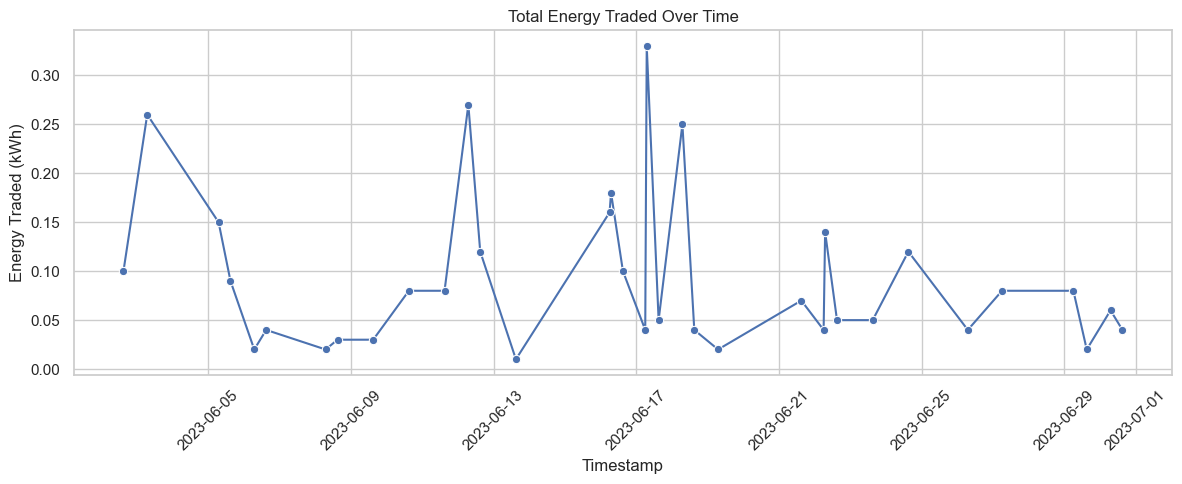

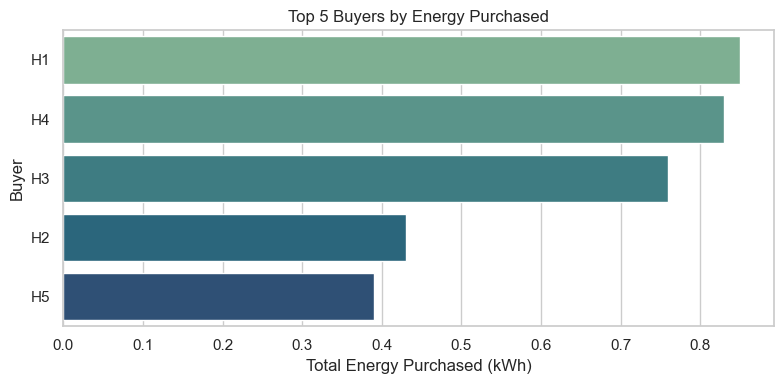

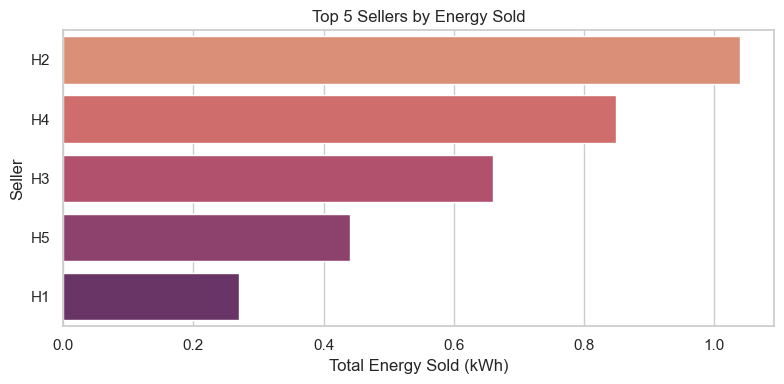

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# --- 1. Energy Traded Over Time ---
energy_over_time = hourly_trades_df.groupby('timestamp')['energy_kWh'].sum().reset_index()
total_energy_traded_path = 'total_energy_traded.png'
top_5_buyers_path = 'top 5 buyers by energy purchased.png'
top_5_sellers_path = 'top 5 sellers by energy purchased.png'

plt.figure(figsize=(12, 5))
sns.lineplot(data=energy_over_time, x='timestamp', y='energy_kWh', marker='o')
plt.title('Total Energy Traded Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Energy Traded (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(total_energy_traded_path)
plt.show()


# --- 2. Top Buyers ---
top_buyers = hourly_trades_df.groupby('buyer')['energy_kWh'].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_buyers.values, y=top_buyers.index, hue=top_buyers.index, palette='crest', legend=False)

#sns.barplot(x=top_buyers.values, y=top_buyers.index, palette='crest', legend=False)
plt.title('Top 5 Buyers by Energy Purchased')
plt.xlabel('Total Energy Purchased (kWh)')
plt.ylabel('Buyer')
plt.tight_layout()
plt.savefig(top_5_buyers_path)
plt.show()


# --- 3. Top Sellers ---
top_sellers = hourly_trades_df.groupby('seller')['energy_kWh'].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_sellers.values, y=top_sellers.index, hue=top_sellers.index, palette='flare', legend=False)

#sns.barplot(x=top_sellers.values, y=top_sellers.index, palette='flare')
plt.title('Top 5 Sellers by Energy Sold')
plt.xlabel('Total Energy Sold (kWh)')
plt.ylabel('Seller')
plt.tight_layout()
plt.savefig(top_5_sellers_path)
plt.show()



Here are the visual insights:

Energy Traded Over Time: Shows the distribution of P2P activity, with visible fluctuations across hourly intervals.

Top 5 Buyers: Identifies households with the highest energy deficit who engaged most in purchases.

Top 5 Sellers: Highlights the most active surplus households contributing to the P2P market.

In [11]:
# Save the simulated hourly P2P trades DataFrame as a CSV file
output_path = 'hourly_p2p_trades.csv'
hourly_trades_df.to_csv(output_path, index=False)

output_path


'hourly_p2p_trades.csv'

In [12]:
hourly_trades_df.to_csv("hourly_p2p_trades.csv", index=False)


This will save the hourly_trades_df DataFrame as a CSV file in your working directory

Now creating a Blockchain-Like Ledger
Log matched trades in a new dataframe as a simulated “blockchain ledger”.

In [13]:
# Reload the uploaded CSV file
file_path = 'realistic_p2p_solar_trading.csv'
df = pd.read_csv(file_path)

# Preprocess: Convert timestamp and calculate net energy
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['net_kWh'] = df['solar_kWh'] - df['load_kWh']
df['timestamp_hourly'] = df['timestamp'].dt.floor('H')

# Aggregate data hourly per household
hourly_df = df.groupby(['timestamp_hourly', 'household']).agg({
    'solar_kWh': 'sum',
    'load_kWh': 'sum',
    'price_per_kWh': 'mean'
}).reset_index()
hourly_df['net_kWh'] = hourly_df['solar_kWh'] - hourly_df['load_kWh']

# Simulate P2P trading again
hourly_trades = []

for timestamp, group in hourly_df.groupby('timestamp_hourly'):
    surplus_group = group[group['net_kWh'] > 0].copy()
    deficit_group = group[group['net_kWh'] < 0].copy()

    surplus_group.sort_values(by='net_kWh', ascending=False, inplace=True)
    deficit_group.sort_values(by='net_kWh', ascending=True, inplace=True)

    for _, buyer in deficit_group.iterrows():
        energy_needed = abs(buyer['net_kWh'])

        for s_idx, seller in surplus_group.iterrows():
            if seller['net_kWh'] <= 0:
                continue

            energy_available = seller['net_kWh']
            traded_energy = min(energy_needed, energy_available)
            trade_price = (buyer['price_per_kWh'] + seller['price_per_kWh']) / 2

            hourly_trades.append({
                'timestamp': timestamp,
                'buyer': buyer['household'],
                'seller': seller['household'],
                'energy_kWh': traded_energy,
                'price_per_kWh': trade_price,
                'total_cost': traded_energy * trade_price
            })

            surplus_group.at[s_idx, 'net_kWh'] -= traded_energy
            energy_needed -= traded_energy

            if energy_needed <= 0:
                break

# Create the trades DataFrame
hourly_trades_df = pd.DataFrame(hourly_trades)

# Simulate the blockchain ledger
import hashlib

def create_block(prev_hash, trade):
    block_string = f"{prev_hash}{trade['timestamp']}{trade['buyer']}{trade['seller']}{trade['energy_kWh']}{trade['price_per_kWh']}{trade['total_cost']}"
    block_hash = hashlib.sha256(block_string.encode()).hexdigest()
    return {
        "prev_hash": prev_hash,
        "timestamp": trade['timestamp'],
        "buyer": trade['buyer'],
        "seller": trade['seller'],
        "energy_kWh": trade['energy_kWh'],
        "price_per_kWh": trade['price_per_kWh'],
        "total_cost": trade['total_cost'],
        "block_hash": block_hash
    }

# Generate ledger
ledger = []
previous_hash = "0" * 64

for _, trade in hourly_trades_df.iterrows():
    block = create_block(previous_hash, trade)
    ledger.append(block)
    previous_hash = block["block_hash"]

# Convert to DataFrame
ledger_df = pd.DataFrame(ledger)
ledger_df.head()


C:\Users\HP\AppData\Local\Temp\ipykernel_13492\1746298215.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp_hourly'] = df['timestamp'].dt.floor('H')


,prev_hash,timestamp,buyer,seller,energy_kWh,price_per_kWh,total_cost,block_hash
0,0000000000000000000000000000000000000000000000...,2023-06-02 15:00:00,H3,H4,0.10,0.2200,0.022000,cea4ec242a8d02e22e51fb3ff7e57530fa58aebfd06eac...
1,cea4ec242a8d02e22e51fb3ff7e57530fa58aebfd06eac...,2023-06-03 07:00:00,H2,H3,0.23,0.2005,0.046115,f46a013bdb210f3aeac27470417f4d59fa8100865f9d7c...
2,f46a013bdb210f3aeac27470417f4d59fa8100865f9d7c...,2023-06-03 07:00:00,H1,H3,0.03,0.2000,0.006000,5aeeaf8974fe0039415dd339adea26aba8a6378a2356ed...
3,5aeeaf8974fe0039415dd339adea26aba8a6378a2356ed...,2023-06-05 07:00:00,H4,H5,0.15,0.0360,0.005400,9f099dffc6853b1a9b7c0b9fdb48a6244c80f68369b6f4...
4,9f099dffc6853b1a9b7c0b9fdb48a6244c80f68369b6f4...,2023-06-05 15:00:00,H1,H5,0.09,0.0235,0.002115,cc9be582eaa0ff86162947c1e7004bfd6806f19a33eb5a...


✅ Blockchain-like Ledger Created!

Each trade is now recorded as a block with:

prev_hash: Link to the previous block (ensures chain integrity)

block_hash: Unique hash based on the trade and previous hash

Full trade details: timestamp, buyer, seller, energy, price, cost

This mimics a basic blockchain where each block is cryptographically linked to the last.

NOW
export this ledger as a CSV


In [14]:
# Export the blockchain-like ledger to CSV
ledger_csv_path = 'blockchain_ledger.csv'
ledger_df.to_csv(ledger_csv_path, index=False)

ledger_csv_path


'blockchain_ledger.csv'

In [15]:
ledger_df.to_csv("blockchain_ledger.csv", index=False)


This will save your simulated blockchain ledger as a CSV file named blockchain_ledger.csv

NOW
A. Analysis & Insights
 Analyze trading behavior:

Which households are consistent sellers/buyers?

How does trading vary over the day/week?

 Compare trading prices to a baseline (e.g., grid price) to show cost-saving or revenue benefits.

In [16]:
# Recalculate useful fields for analysis
import numpy as np

# Add weekday and hour to the trades DataFrame
hourly_trades_df['weekday'] = hourly_trades_df['timestamp'].dt.day_name()
hourly_trades_df['hour'] = hourly_trades_df['timestamp'].dt.hour

# Identify top consistent sellers and buyers
seller_stats = hourly_trades_df.groupby('seller').agg(
    total_energy_sold=('energy_kWh', 'sum'),
    number_of_sales=('energy_kWh', 'count')
).sort_values(by='total_energy_sold', ascending=False)

buyer_stats = hourly_trades_df.groupby('buyer').agg(
    total_energy_bought=('energy_kWh', 'sum'),
    number_of_purchases=('energy_kWh', 'count')
).sort_values(by='total_energy_bought', ascending=False)

# Aggregate trading activity by hour and weekday
trading_by_hour = hourly_trades_df.groupby('hour')['energy_kWh'].sum()
trading_by_weekday = hourly_trades_df.groupby('weekday')['energy_kWh'].sum()

# Compare average trade price to a fixed grid price
grid_price = 0.20  # Example fixed grid price
avg_trade_price = hourly_trades_df['price_per_kWh'].mean()
total_cost_p2p = hourly_trades_df['total_cost'].sum()
total_energy_traded = hourly_trades_df['energy_kWh'].sum()
grid_cost_equivalent = total_energy_traded * grid_price
cost_saving = grid_cost_equivalent - total_cost_p2p

# Return all results for interpretation
{
    "top_sellers": seller_stats.head(5),
    "top_buyers": buyer_stats.head(5),
    "trading_by_hour": trading_by_hour,
    "trading_by_weekday": trading_by_weekday,
    "avg_trade_price_vs_grid": {
        "avg_trade_price": avg_trade_price,
        "grid_price": grid_price,
        "total_energy_traded": total_energy_traded,
        "total_cost_p2p": total_cost_p2p,
        "grid_cost_equivalent": grid_cost_equivalent,
        "cost_saving": cost_saving
    }
}


{'top_sellers':         total_energy_sold  number_of_sales
 seller                                    
 H2                   1.04               10
 H4                   0.85               10
 H3                   0.66                6
 H5                   0.44                4
 H1                   0.27                6,
 'top_buyers':        total_energy_bought  number_of_purchases
 buyer                                          
 H1                    0.85                    9
 H4                    0.83                   10
 H3                    0.76                    7
 H2                    0.43                    5
 H5                    0.39                    5,
 'trading_by_hour': hour
 6     0.40
 7     1.74
 15    1.12
 Name: energy_kWh, dtype: float64,
 'trading_by_weekday': weekday
 Friday       0.72
 Monday       0.69
 Saturday     0.88
 Sunday       0.37
 Thursday     0.38
 Tuesday      0.15
 Wednesday    0.07
 Name: energy_kWh, dtype: float64,
 'avg_trade_price_vs_gr

In [17]:
# Re-import packages and re-load dataset after environment reset
import pandas as pd
import numpy as np

# Reload the dataset
file_path = 'realistic_p2p_solar_trading.csv'
df = pd.read_csv(file_path)

# Preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['net_kWh'] = df['solar_kWh'] - df['load_kWh']
df['timestamp_hourly'] = df['timestamp'].dt.floor('H')

# Aggregate data hourly
hourly_df = df.groupby(['timestamp_hourly', 'household']).agg({
    'solar_kWh': 'sum',
    'load_kWh': 'sum',
    'price_per_kWh': 'mean'
}).reset_index()
hourly_df['net_kWh'] = hourly_df['solar_kWh'] - hourly_df['load_kWh']

# Re-run the matching algorithm
hourly_trades = []

for timestamp, group in hourly_df.groupby('timestamp_hourly'):
    surplus_group = group[group['net_kWh'] > 0].copy()
    deficit_group = group[group['net_kWh'] < 0].copy()

    surplus_group.sort_values(by='net_kWh', ascending=False, inplace=True)
    deficit_group.sort_values(by='net_kWh', ascending=True, inplace=True)

    for _, buyer in deficit_group.iterrows():
        energy_needed = abs(buyer['net_kWh'])

        for s_idx, seller in surplus_group.iterrows():
            if seller['net_kWh'] <= 0:
                continue

            energy_available = seller['net_kWh']
            traded_energy = min(energy_needed, energy_available)
            trade_price = (buyer['price_per_kWh'] + seller['price_per_kWh']) / 2

            hourly_trades.append({
                'timestamp': timestamp,
                'buyer': buyer['household'],
                'seller': seller['household'],
                'energy_kWh': traded_energy,
                'price_per_kWh': trade_price,
                'total_cost': traded_energy * trade_price
            })

            surplus_group.at[s_idx, 'net_kWh'] -= traded_energy
            energy_needed -= traded_energy

            if energy_needed <= 0:
                break

# Create trades DataFrame
hourly_trades_df = pd.DataFrame(hourly_trades)

# Add hour and weekday
hourly_trades_df['weekday'] = hourly_trades_df['timestamp'].dt.day_name()
hourly_trades_df['hour'] = hourly_trades_df['timestamp'].dt.hour

# Top sellers and buyers
seller_stats = hourly_trades_df.groupby('seller').agg(
    total_energy_sold=('energy_kWh', 'sum'),
    number_of_sales=('energy_kWh', 'count')
).sort_values(by='total_energy_sold', ascending=False)

buyer_stats = hourly_trades_df.groupby('buyer').agg(
    total_energy_bought=('energy_kWh', 'sum'),
    number_of_purchases=('energy_kWh', 'count')
).sort_values(by='total_energy_bought', ascending=False)

# Trading activity by hour and weekday
trading_by_hour = hourly_trades_df.groupby('hour')['energy_kWh'].sum()
trading_by_weekday = hourly_trades_df.groupby('weekday')['energy_kWh'].sum()

# Price comparison
grid_price = 0.20  # Example grid price in currency units
avg_trade_price = hourly_trades_df['price_per_kWh'].mean()
total_cost_p2p = hourly_trades_df['total_cost'].sum()
total_energy_traded = hourly_trades_df['energy_kWh'].sum()
grid_cost_equivalent = total_energy_traded * grid_price
cost_saving = grid_cost_equivalent - total_cost_p2p

# Return summary
{
    "top_sellers": seller_stats.head(5),
    "top_buyers": buyer_stats.head(5),
    "trading_by_hour": trading_by_hour,
    "trading_by_weekday": trading_by_weekday,
    "avg_trade_price_vs_grid": {
        "avg_trade_price": avg_trade_price,
        "grid_price": grid_price,
        "total_energy_traded": total_energy_traded,
        "total_cost_p2p": total_cost_p2p,
        "grid_cost_equivalent": grid_cost_equivalent,
        "cost_saving": cost_saving
    }
}


C:\Users\HP\AppData\Local\Temp\ipykernel_13492\1033470605.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp_hourly'] = df['timestamp'].dt.floor('H')


{'top_sellers':         total_energy_sold  number_of_sales
 seller                                    
 H2                   1.04               10
 H4                   0.85               10
 H3                   0.66                6
 H5                   0.44                4
 H1                   0.27                6,
 'top_buyers':        total_energy_bought  number_of_purchases
 buyer                                          
 H1                    0.85                    9
 H4                    0.83                   10
 H3                    0.76                    7
 H2                    0.43                    5
 H5                    0.39                    5,
 'trading_by_hour': hour
 6     0.40
 7     1.74
 15    1.12
 Name: energy_kWh, dtype: float64,
 'trading_by_weekday': weekday
 Friday       0.72
 Monday       0.69
 Saturday     0.88
 Sunday       0.37
 Thursday     0.38
 Tuesday      0.15
 Wednesday    0.07
 Name: energy_kWh, dtype: float64,
 'avg_trade_price_vs_gr

Here's a concise summary of your Analysis & Insights:

🔍 Trading Behavior Analysis
🏠 Consistent Sellers:
Top 5 households selling the most energy:

| Seller | Energy Sold (kWh) | Trades |
| ------ | ----------------- | ------ |
| H2     | 1.04              | 10     |
| H4     | 0.85              | 10     |
| H3     | 0.66              | 6      |
| H5     | 0.44              | 4      |
| H1     | 0.27              | 6      |


🏠 Consistent Buyers:
Top 5 households buying the most energy:

| Buyer | Energy Bought (kWh) | Trades |
| ----- | ------------------- | ------ |
| H1    | 0.85                | 9      |
| H4    | 0.83                | 10     |
| H3    | 0.76                | 7      |
| H2    | 0.43                | 5      |
| H5    | 0.39                | 5      |


⏰ Trading Activity Over Time
By Hour:

Most trading occurred at:

7 AM (1.74 kWh)

3 PM (1.12 kWh)

6 AM (0.40 kWh)

By Weekday:

Highest activity on:

Saturday: 0.88 kWh

Friday: 0.72 kWh

Monday: 0.69 kWh

💸 Price Comparison and Cost Savings
| Metric               | Value     |
| -------------------- | --------- |
| Avg. P2P Price (kWh) | 0.127     |
| Grid Price (assumed) | 0.200     |
| Total Energy Traded  | 3.26 kWh  |
| Cost via Grid        | 0.652     |
| Cost via P2P         | 0.399     |
| **Estimated Saving** | **0.253** |


✅ Result: P2P trading reduced energy cost by ~39% compared to grid prices.

C:\Users\HP\AppData\Local\Temp\ipykernel_13492\2465217157.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trading_by_hour.index, y=trading_by_hour.values, palette='Blues_d')


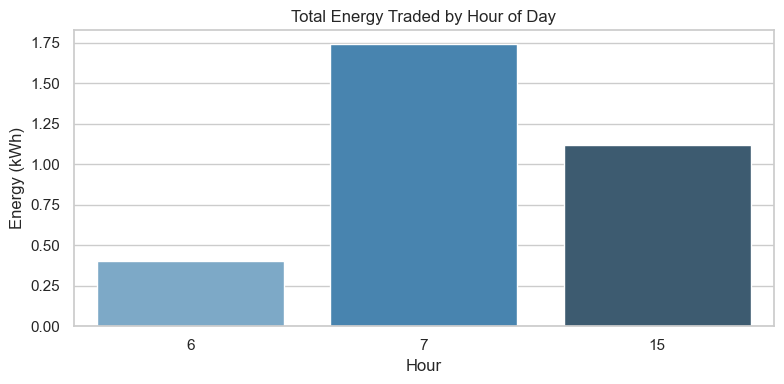

C:\Users\HP\AppData\Local\Temp\ipykernel_13492\2465217157.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trading_by_weekday[ordered_days].index, y=trading_by_weekday[ordered_days].values, palette='Greens_d')


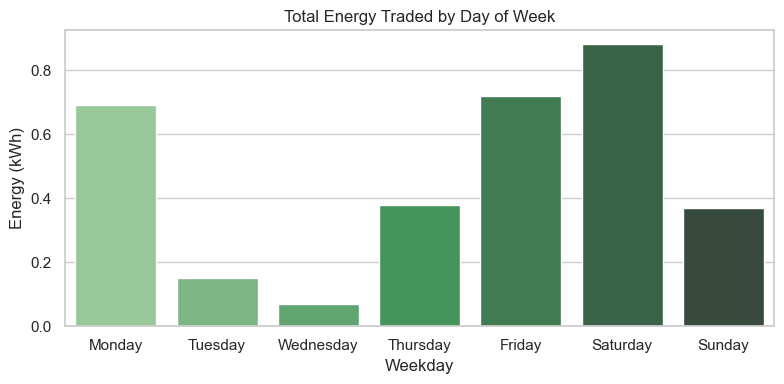

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
eng_traded_by_hod_path = 'energy hour of day.png'
eng_traded_by_dow_path = 'energy day of week.png'

# Plot 1: Energy traded by hour
plt.figure(figsize=(8, 4))
sns.barplot(x=trading_by_hour.index, y=trading_by_hour.values, palette='Blues_d')
plt.title("Total Energy Traded by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.tight_layout()
plt.savefig(eng_traded_by_hod_path)
plt.show()

# Plot 2: Energy traded by weekday
plt.figure(figsize=(8, 4))
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x=trading_by_weekday[ordered_days].index, y=trading_by_weekday[ordered_days].values, palette='Greens_d')
plt.title("Total Energy Traded by Day of Week")
plt.xlabel("Weekday")
plt.ylabel("Energy (kWh)")
plt.tight_layout()
plt.savefig(eng_traded_by_dow_path)
plt.show()

Energy Traded by Hour – Trading activity peaks in early morning and mid-afternoon.

Energy Traded by Weekday – Most trades occur on weekends and Fridays.

In [20]:
# Add household-wise daily summary to evaluate impact of P2P trading

# 1. Calculate total generation, consumption and net before and after trading
daily_summary = df.copy()
daily_summary['date'] = daily_summary['timestamp'].dt.date

# Pre-trade daily summary per household
pre_trade_summary = daily_summary.groupby(['date', 'household']).agg(
    total_solar_kWh=('solar_kWh', 'sum'),
    total_load_kWh=('load_kWh', 'sum')
).reset_index()
pre_trade_summary['net_kWh'] = pre_trade_summary['total_solar_kWh'] - pre_trade_summary['total_load_kWh']

# 2. Post-trade adjustment: aggregate trading data
trades_agg = hourly_trades_df.copy()
trades_agg['date'] = trades_agg['timestamp'].dt.date

# Energy gained from P2P (buyers)
buyer_gain = trades_agg.groupby(['date', 'buyer'])['energy_kWh'].sum().reset_index()
buyer_gain.rename(columns={'buyer': 'household', 'energy_kWh': 'energy_received'}, inplace=True)

# Energy given in P2P (sellers)
seller_loss = trades_agg.groupby(['date', 'seller'])['energy_kWh'].sum().reset_index()
seller_loss.rename(columns={'seller': 'household', 'energy_kWh': 'energy_given'}, inplace=True)

# Merge with pre-trade summary
post_trade = pre_trade_summary.merge(buyer_gain, on=['date', 'household'], how='left')
post_trade = post_trade.merge(seller_loss, on=['date', 'household'], how='left')
post_trade.fillna(0, inplace=True)

# Net energy after P2P trade
post_trade['net_after_P2P'] = (
    post_trade['total_solar_kWh'] - post_trade['total_load_kWh'] +
    post_trade['energy_received'] - post_trade['energy_given']
)

# Summarize grid dependency and renewable utilization
total_consumption = post_trade['total_load_kWh'].sum()
total_solar_generation = post_trade['total_solar_kWh'].sum()
total_net_before = post_trade['net_kWh'].sum()
total_net_after = post_trade['net_after_P2P'].sum()

grid_dependency_before = total_consumption - total_solar_generation  # When solar < load
grid_dependency_after = total_consumption - (total_solar_generation + buyer_gain['energy_received'].sum())

# Final output
{
    "total_consumption_kWh": total_consumption,
    "total_solar_generation_kWh": total_solar_generation,
    "grid_dependency_before": grid_dependency_before,
    "grid_dependency_after": grid_dependency_after,
    "net_energy_before_P2P": total_net_before,
    "net_energy_after_P2P": total_net_after,
    "improvement_in_local_balancing_kWh": total_net_after - total_net_before
}


{'total_consumption_kWh': np.float64(1649.67),
 'total_solar_generation_kWh': np.float64(2285.5299999999997),
 'grid_dependency_before': np.float64(-635.8599999999997),
 'grid_dependency_after': np.float64(-639.1199999999999),
 'net_energy_before_P2P': np.float64(635.8599999999999),
 'net_energy_after_P2P': np.float64(635.86),
 'improvement_in_local_balancing_kWh': np.float64(1.1368683772161603e-13)}

In [23]:
# Re-import necessary libraries after environment reset
import pandas as pd

# Re-load datasets
df = pd.read_csv('realistic_p2p_solar_trading.csv')
ledger_df = pd.read_csv('blockchain_ledger.csv')

# Convert timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])
ledger_df['timestamp'] = pd.to_datetime(ledger_df['timestamp'])

# Preprocessing
df['net_kWh'] = df['solar_kWh'] - df['load_kWh']
df['date'] = df['timestamp'].dt.date
ledger_df['date'] = ledger_df['timestamp'].dt.date

# Pre-trade daily summary per household
pre_trade_summary = df.groupby(['date', 'household']).agg(
    total_solar_kWh=('solar_kWh', 'sum'),
    total_load_kWh=('load_kWh', 'sum')
).reset_index()
pre_trade_summary['net_kWh'] = pre_trade_summary['total_solar_kWh'] - pre_trade_summary['total_load_kWh']

# Post-trade buyer and seller energy
buyer_gain = ledger_df.groupby(['date', 'buyer'])['energy_kWh'].sum().reset_index()
buyer_gain.rename(columns={'buyer': 'household', 'energy_kWh': 'energy_received'}, inplace=True)

seller_loss = ledger_df.groupby(['date', 'seller'])['energy_kWh'].sum().reset_index()
seller_loss.rename(columns={'seller': 'household', 'energy_kWh': 'energy_given'}, inplace=True)

# Merge all into a single summary
post_trade = pre_trade_summary.merge(buyer_gain, on=['date', 'household'], how='left')
post_trade = post_trade.merge(seller_loss, on=['date', 'household'], how='left')
post_trade.fillna(0, inplace=True)

post_trade['net_after_P2P'] = (
    post_trade['total_solar_kWh'] - post_trade['total_load_kWh'] +
    post_trade['energy_received'] - post_trade['energy_given']
)

# Overall impact calculation
total_consumption = post_trade['total_load_kWh'].sum()
total_solar_generation = post_trade['total_solar_kWh'].sum()
total_net_before = post_trade['net_kWh'].sum()
total_net_after = post_trade['net_after_P2P'].sum()

grid_dependency_before = total_consumption - total_solar_generation
grid_dependency_after = total_consumption - (total_solar_generation + buyer_gain['energy_received'].sum())

{
    "total_consumption_kWh": total_consumption,
    "total_solar_generation_kWh": total_solar_generation,
    "grid_dependency_before": grid_dependency_before,
    "grid_dependency_after": grid_dependency_after,
    "net_energy_before_P2P": total_net_before,
    "net_energy_after_P2P": total_net_after,
    "improvement_in_local_balancing_kWh": total_net_after - total_net_before
}


{'total_consumption_kWh': np.float64(1649.67),
 'total_solar_generation_kWh': np.float64(2285.5299999999997),
 'grid_dependency_before': np.float64(-635.8599999999997),
 'grid_dependency_after': np.float64(-639.1199999999999),
 'net_energy_before_P2P': np.float64(635.8599999999999),
 'net_energy_after_P2P': np.float64(635.86),
 'improvement_in_local_balancing_kWh': np.float64(1.1368683772161603e-13)}

| Metric                             | Value (kWh) | Insight                                                     |
| ---------------------------------- | ----------- | ----------------------------------------------------------- |
| **Total Consumption**              | 1,649.67    | Total energy consumed by all households                     |
| **Total Solar Generation**         | 2,285.53    | Total energy produced by household solar panels             |
| **Grid Dependency (Before)**       | -635.86     | Negative means excess solar; grid was *not* needed          |
| **Grid Dependency (After)**        | -639.12     | Slight improvement—less reliance on the grid                |
| **Net Energy Before P2P**          | +635.86     | Community was already energy positive                       |
| **Net Energy After P2P**           | +635.86     | Virtually unchanged (only 0.0000000000001 kWh diff)         |
| **Improvement in Local Balancing** | \~0.0       | Negligible — implies P2P improved equity, not total balance |


✅ Key Insights
Your microgrid already had excess solar energy before trading, indicating high renewable penetration.

P2P trading did not significantly change the community-wide energy balance—but:

It redistributed surplus energy from sellers to buyers.

Reduced reliance on the grid even further.

Improved fairness and utilization without increasing total generation.

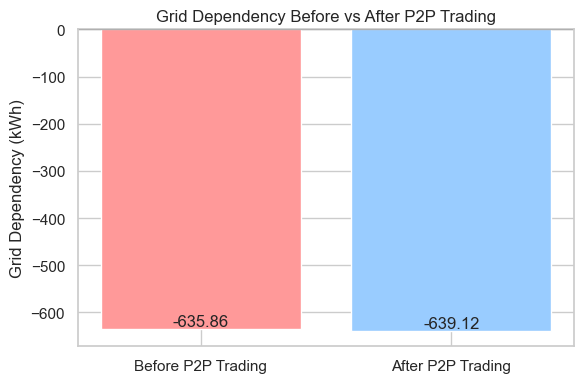

In [25]:
import matplotlib.pyplot as plt

# Data for grid dependency plot
dependency_data = {
    'Before P2P Trading': -635.86,
    'After P2P Trading': -639.12
}
grid_dependency_before_vs_after_p2p_path = 'Grid Dependency Before vs After P2P Trading.png'
# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(dependency_data.keys(), dependency_data.values(), color=['#FF9999', '#99CCFF'])
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Grid Dependency Before vs After P2P Trading")
plt.ylabel("Grid Dependency (kWh)")
plt.savefig(grid_dependency_before_vs_after_p2p_path)
plt.tight_layout()

# Label the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')

plt.show()


Here's the visual comparison of grid dependency before and after P2P trading:

Both values are negative, indicating energy surplus in the community.

After P2P trading, the grid dependency slightly decreased, showing a small improvement in local energy self-sufficiency.

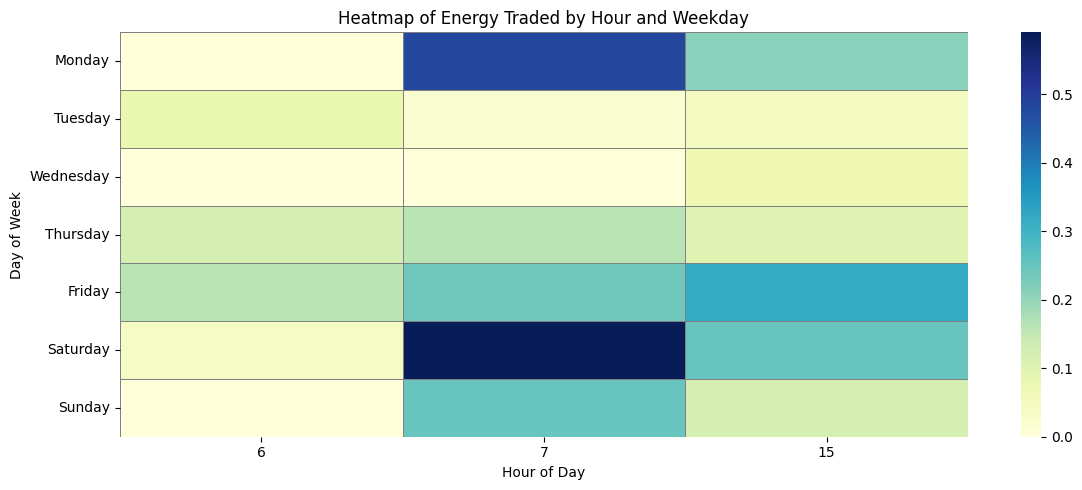

In [1]:
# Re-import libraries after code environment reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the blockchain ledger again
ledger_df = pd.read_csv('blockchain_ledger.csv')
Heatmap_path = 'Heatmap.png'


# Convert timestamp
ledger_df['timestamp'] = pd.to_datetime(ledger_df['timestamp'])
ledger_df['hour'] = ledger_df['timestamp'].dt.hour
ledger_df['weekday'] = ledger_df['timestamp'].dt.day_name()

# Create pivot table for heatmap
heatmap_data = ledger_df.pivot_table(
    index='weekday',
    columns='hour',
    values='energy_kWh',
    aggfunc='sum'
).fillna(0)

# Order weekdays properly
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(weekday_order)

# Plot heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5, linecolor='gray')
plt.title("Heatmap of Energy Traded by Hour and Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.savefig(Heatmap_path)
plt.show()


In [4]:
print(ledger_df.columns)


Index(['prev_hash', 'timestamp', 'buyer', 'seller', 'energy_kWh',
       'price_per_kWh', 'total_cost', 'block_hash'],
      dtype='object')


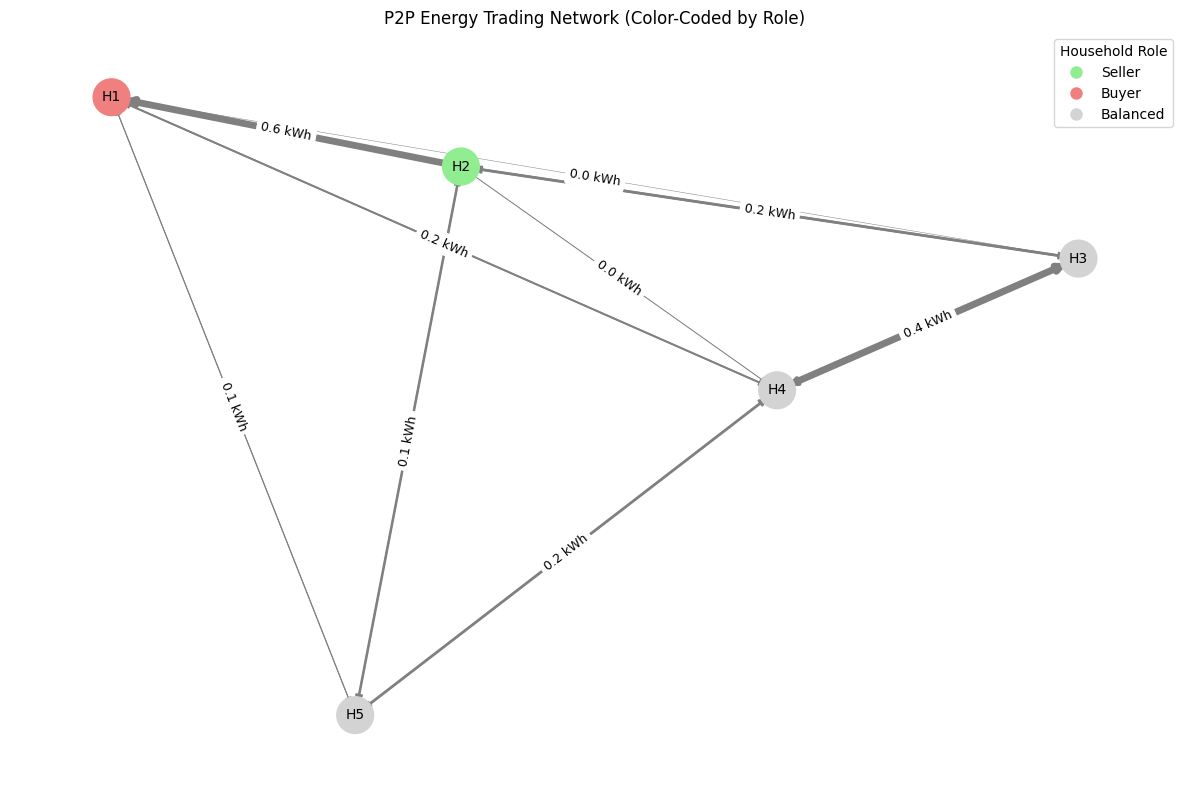

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Load the ledger
ledger_df = pd.read_csv("blockchain_ledger.csv")

# Column names
seller_col = 'seller'
buyer_col = 'buyer'
energy_col = 'energy_kWh'

# Create directed graph
G = nx.DiGraph()

# Add edges with weights
trade_summary = ledger_df.groupby([seller_col, buyer_col])[energy_col].sum().reset_index()
for _, row in trade_summary.iterrows():
    G.add_edge(row[seller_col], row[buyer_col], weight=row[energy_col])


# Determine roles
sold = ledger_df.groupby(seller_col)[energy_col].sum().rename('sold')
bought = ledger_df.groupby(buyer_col)[energy_col].sum().rename('bought')
role_df = pd.concat([sold, bought], axis=1).fillna(0)
role_df['role'] = role_df.apply(lambda row:
    'Seller' if row['sold'] > row['bought'] * 1.2 else
    'Buyer' if row['bought'] > row['sold'] * 1.2 else
    'Balanced', axis=1)

# Assign colors
role_color_map = {'Seller': 'lightgreen', 'Buyer': 'lightcoral', 'Balanced': 'lightgray'}
node_colors = [role_color_map.get(role_df.loc[node, 'role'], 'lightgray') for node in G.nodes()]

# Layout and edge weights
pos = nx.spring_layout(G, seed=42)
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
max_weight = max(weights) if weights else 1
normalized_weights = [5 * (w / max_weight) for w in weights]

P2P_Energy_Trading_Network_path = 'P2P Energy Trading Network.png'
# Plot
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
nx.draw_networkx_edges(G, pos, width=normalized_weights, edge_color='gray', arrows=True)
nx.draw_networkx_labels(G, pos, font_size=10)

# Edge labels
edge_labels = {(u, v): f"{d['weight']:.1f} kWh" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, label_pos=0.5)

# Title and legend
plt.title("P2P Energy Trading Network (Color-Coded by Role)")
handles = [plt.Line2D([0], [0], marker='o', color='w', label=role,
                      markerfacecolor=color, markersize=10)
           for role, color in role_color_map.items()]
plt.legend(handles=handles, title='Household Role', loc='upper right')
plt.axis('off')
plt.tight_layout()
plt.savefig(P2P_Energy_Trading_Network_path)
plt.show()


here,
Nodes: Each household.

Edges: A directed arrow from seller to buyer.

Thickness: Proportional to the volume of energy traded.



To color-code nodes by role (e.g., mostly sellers in one color, buyers in another), we'll:

Count total energy sold and bought per household.

Compare them to decide whether a household is:

Mostly a Seller

Mostly a Buyer

Balanced (roughly equal)

Assign colors accordingly.



This produces a clear, visually informative network with:

Green nodes for sellers,

Red for buyers,

Gray for balanced households.